In [1]:
import numpy as np
from ase.io import read, write
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
def process(traj, shieldings):
    output = {}
    output_error = {}

    number = traj[0].numbers

    for species in [1,6,7,8]:
        output[species] = []
        output_error[species] = []
        types = shieldings[np.where(number == species )[0]]
        for type in np.unique(types):
            output[species].append(np.concatenate([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj])) 
            output_error[species].append(np.concatenate([frame.arrays['CSerr'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj]))       
    return output, output_error

def compute_averages(poly_cs, poly_cs_err):
    symbols = list(poly_cs.keys())
    averages = np.array([])
    errors = np.array([])
    for symbol in symbols:
        for ind, shielding in enumerate(poly_cs[symbol]):
            ave  = np.mean(shielding)

            N1 = len(shielding)
            N2 = len(poly_cs_err[symbol][ind])

            err1 = np.std(shielding)/np.sqrt(N1)
            #err2 = np.sum([i for i in poly_cs_err[symbol][ind]])/N2

            err2 = np.sqrt(np.sum([i**2 for i in poly_cs_err[symbol][ind]])/N2)
            

            err = np.sqrt( err1**2 + err2**2)
            #err = err1
            averages = np.append(averages, ave)
            errors = np.append(errors, err)
    return np.stack((averages, errors))
            


def plot_shieldings(shieldings_values, ax, fig, color="k", lab= "label", symbols_to_plot=None, shieldings_to_plot=None):
    labels = {1 : "H", 6: "C", 7 : "N", 8 : "O"}
    
    if symbols_to_plot == None:
        symbols = list(shieldings_values.keys())
    else:
        symbols = symbols_to_plot

    
    for ind, el in  zip(range(len(symbols)), symbols):
        if len(symbols) == 1:
            my_axis = ax
        else:
            my_axis = ax[ind]
        my_axis.tick_params(axis='both', which='major', labelsize=14)
        my_axis.tick_params(axis='both', which='minor', labelsize=12)

        for ind1, shielding in enumerate(shieldings_values[el]):
            if (shieldings_to_plot == None) or ((ind1 + 1) in shieldings_to_plot):
                if isinstance(shielding, (list, np.ndarray)) and len(shielding) >= 100:

                    density = gaussian_kde(shielding)
                    xs = np.linspace(min(shielding),max(shielding),200)
                    density.covariance_factor = lambda : .25
                    density._compute_covariance()
                    my_axis.plot(xs, density(xs), color=color, linewidth=2)

                my_axis.vlines(np.mean(shielding), ymin= 0, ymax=0.3, colors=color, linestyles="dashed", linewidth=2)
        if (shieldings_to_plot == None) or ((ind1 + 1) in shieldings_to_plot):        
            my_axis.vlines(np.mean(shielding), ymin= 0, ymax=0.3, colors=color, linestyles="dashed", label= lab, linewidth=2)

        my_axis.set_title(labels[symbols[ind]], fontsize=16)
    my_axis.set_xlabel("Shielding (ppm)", fontsize=16)

    my_axis.legend(fontsize=14)


In [3]:
edgars_results = {
    'glycine_alpha': {
        1 : np.array([25.24, 26.59, 21.07]),
        6 : np.array([-8.64, 126.26]),
        7 : np.array([191.82])
    },
    'glycine_beta': {
        1: np.array([26.13, 26.91, 21.16]),
        6: np.array([-5.73, 127.86]),
        7: np.array([194.45])
    },
    'glycine_gamma': {
        1 : np.array([26.53, 27.11, 20.86]),
        6 : np.array([-5.01, 128.34]),
        7 : np.array([191.37])
    }
}


colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [4]:
# load stuff

path_to_file = "PI_NVT/glycine_shieldings/"

base_fn = lambda poly, type, average: path_to_file + f'pi_nvt_{type}_glycine_{poly}_300K_00_w_cs{average}.xyz'

lmp_traj_alpha = read(base_fn('alpha', "lmp", ""),':')
lmp_traj_gamma  = read(base_fn('gamma', "lmp", ""),':')
lmp_traj_beta = read(base_fn('beta', "lmp", ""),':')

lmp_traj_alpha_edgar = read(base_fn('alpha', "lmp", "_edgar_traj"),':')
lmp_traj_gamma_edgar = read(base_fn('gamma', "lmp", "_edgar_traj"),':')
lmp_traj_beta_edgar = read(base_fn('beta', "lmp", "_edgar_traj"),':')

mlp_traj_alpha = read(base_fn('alpha', "MLP", ""),':')
mlp_traj_gamma  = read(base_fn('gamma', "MLP", ""),':')
mlp_traj_beta  = read(base_fn('beta', "MLP", ""),':')

mlp_traj_gamma_small  = read('PI_NVT/glycine_shieldings/pi_nvt_lmp_glycine_gamma_300K_00_w_cs_only_dftb.xyz',':')

# aditis potential
mlp_traj_gamma_aditi  = read('PI_NVT/glycine_shieldings/MLP_aditi/pi_nvt_MLP_glycine_gamma_300K_00_w_cs_aditi.xyz',':')
mlp_traj_beta_aditi  = read('PI_NVT/glycine_shieldings/MLP_aditi/pi_nvt_MLP_glycine_beta_300K_00_w_cs_aditi.xyz',':')



lmp_traj_ave_alpha = read(base_fn('alpha', "lmp", "_averaged"),':')[0]
lmp_traj_ave_gamma  = read(base_fn('gamma', "lmp", "_averaged"),':')[0]
lmp_traj_ave_beta = read(base_fn('beta', "lmp", "_averaged"),':')[0]

#mlp_traj_ave_alpha = read(base_fn('alpha', "mlp", "_averaged"),':')[0]
#mlp_traj_ave_gamma  = read(base_fn('gamma', "mlp", "_averaged"),':')[0]
#mlp_traj_ave_beta  = read(base_fn('beta', "mlp", "_averaged"),':')[0]

# load shieldings

path_to_init_file = "PI_NVT/"

base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'


alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")

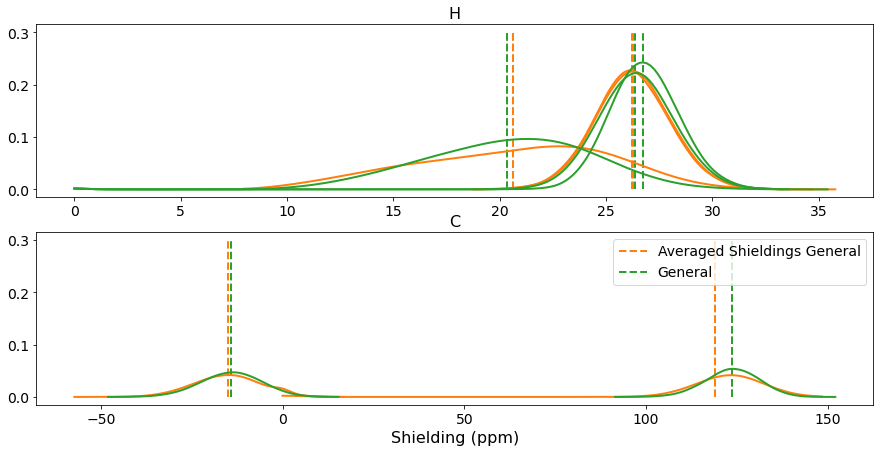

In [13]:
gamma_cs_lmp, gamma_cs_lmp_err  = process(lmp_traj_gamma, gamma_shieldings)
gamma_cs_mlp, gamma_cs_mlp_err  = process(mlp_traj_gamma, gamma_shieldings)
gamma_cs_mlp_aditi, gamma_cs_mlp_aditi_err = process(mlp_traj_gamma_aditi, gamma_shieldings)
gamma_cs_mlp_small, gamma_cs_mlp_small_err = process(mlp_traj_gamma_small, gamma_shieldings)
gamma_cs_lmp_edgar, gamma_cs_lmp_edgar_err = process(lmp_traj_gamma_edgar, gamma_shieldings)

gamma_cs_lmp_ave, _ = process([lmp_traj_ave_gamma], gamma_shieldings)
#gamma_cs_mlp_ave, _ = process([mlp_traj_ave_gamma], gamma_shieldings)

symbols_to_plot = [1,6]

fig, ax = plt.subplots(ncols=1, nrows=len(symbols_to_plot ), sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)


#plot_shieldings(gamma_cs_lmp, ax, fig, colors[0], "Bespoke Potential", symbols_to_plot = symbols_to_plot )
plot_shieldings(gamma_cs_mlp_aditi, ax, fig, colors[1], "Averaged Shieldings General", symbols_to_plot =symbols_to_plot )
#plot_shieldings(gamma_cs_mlp_small, ax, fig, colors[3], "Edgars trajectory", symbols_to_plot =symbols_to_plot )
#plot_shieldings(gamma_cs_lmp_ave, ax, fig, colors[3], "Averaged Descriptor - Bespoke", symbols_to_plot = symbols_to_plot )
plot_shieldings(gamma_cs_mlp, ax, fig, colors[2], "General", symbols_to_plot = symbols_to_plot )
#plot_shieldings(edgars_results["glycine_gamma"], ax, fig, colors[4], "edgars_results", symbols_to_plot =symbols_to_plot )

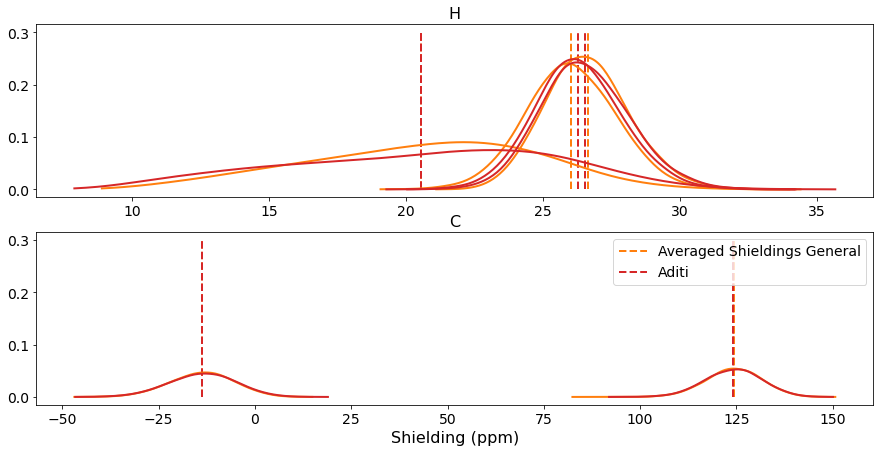

In [12]:
beta_cs_lmp, beta_cs_lmp_err = process(lmp_traj_beta, beta_shieldings)
beta_cs_mlp, beta_cs_mlp_err = process(mlp_traj_beta, beta_shieldings)
beta_cs_lmp_edgar, beta_cs_lmp_edgar_err = process(lmp_traj_beta_edgar, beta_shieldings)
beta_cs_mlp_aditi, beta_cs_mlp_aditi_err = process(mlp_traj_beta_aditi, beta_shieldings)


beta_cs_lmp_ave, _ = process([lmp_traj_ave_beta], beta_shieldings)
#beta_cs_mlp_ave, _ = process([mlp_traj_ave_beta], beta_shieldings)

symbols_to_plot = [1,6]

fig, ax = plt.subplots(ncols=1, nrows=len(symbols_to_plot), sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)

#plot_shieldings(beta_cs_lmp, ax, fig, colors[0], "Bespoke potential", symbols_to_plot = symbols_to_plot )
plot_shieldings(beta_cs_mlp, ax, fig, colors[1], "Averaged Shieldings General", symbols_to_plot =symbols_to_plot )
plot_shieldings(beta_cs_mlp_aditi, ax, fig, colors[3], "Aditi", symbols_to_plot = symbols_to_plot )
#plot_shieldings(beta_cs_mlp_ave, ax, fig, colors[2], "Averaged Descriptor - General", symbols_to_plot = symbols_to_plot )
#plot_shieldings(edgars_results["glycine_beta"], ax, fig, colors[4], "edgars_results", symbols_to_plot = symbols_to_plot )

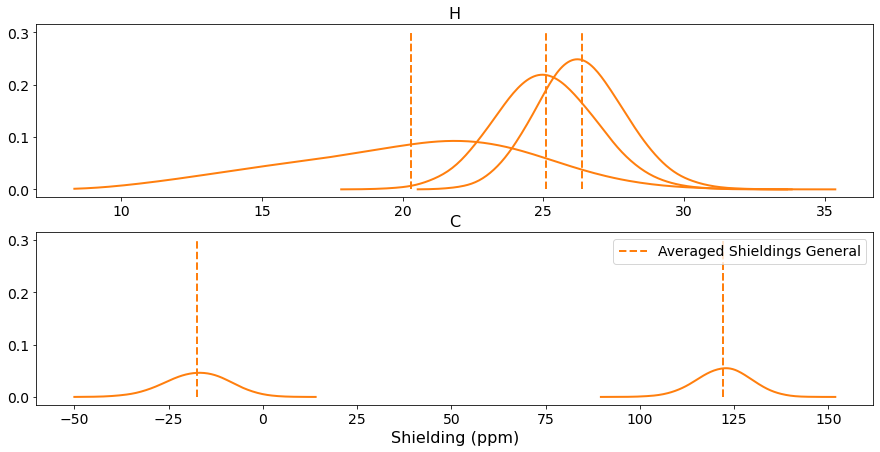

In [10]:
alpha_cs_lmp, alpha_cs_lmp_err = process(lmp_traj_alpha, alpha_shieldings)
alpha_cs_mlp, alpha_cs_mlp_err = process(mlp_traj_alpha, alpha_shieldings)
alpha_cs_lmp_edgar, alpha_cs_lmp_edgar_err = process(lmp_traj_alpha_edgar, alpha_shieldings)


alpha_cs_lmp_ave, _ = process([lmp_traj_ave_alpha], alpha_shieldings)
#alpha_cs_mlp_ave, _ = process([mlp_traj_ave_alpha], alpha_shieldings)

symbols_to_plot = [1,6]

fig, ax = plt.subplots(ncols=1, nrows=len(symbols_to_plot), sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)

#plot_shieldings(alpha_cs_lmp, ax, fig, colors[0], "Bespoke Potential", symbols_to_plot = symbols_to_plot )
plot_shieldings(alpha_cs_mlp, ax, fig, colors[1], "Averaged Shieldings General", symbols_to_plot =symbols_to_plot )
#plot_shieldings(alpha_cs_lmp_edgar, ax, fig, colors[3], "Edgars trajectory", symbols_to_plot = symbols_to_plot )
#plot_shieldings(alpha_cs_mlp_ave, ax, fig, colors[2], "Averaged Descriptor - General", symbols_to_plot = symbols_to_plot )
#plot_shieldings(edgars_results["glycine_alpha"], ax, fig, colors[4], "edgars_results", symbols_to_plot =symbols_to_plot )

In [27]:
gamma_averages = compute_averages(gamma_cs_mlp, gamma_cs_lmp_err)
beta_averages = compute_averages(beta_cs_lmp_ave, gamma_cs_lmp_err)
alpha_averages = compute_averages(alpha_cs_lmp_ave, gamma_cs_lmp_err)


In [23]:
np.transpose(compute_averages(gamma_cs_mlp_aditi, gamma_cs_mlp_aditi_err), axes=None)

array([[ 26.20973877,   0.26029023],
       [ 26.2699358 ,   0.26332243],
       [ 20.64096644,   0.31818768],
       [-14.98981167,   1.15576543],
       [118.9217562 ,   1.5630592 ],
       [189.47644114,   1.97943657],
       [-76.14684329,   9.68466097],
       [-59.20327561,   9.17701799]])

In [10]:
gamma_averages = compute_averages(gamma_cs_lmp_edgar, gamma_cs_lmp_edgar_err)
beta_averages = compute_averages(beta_cs_lmp_edgar, beta_cs_lmp_edgar_err)
alpha_averages = compute_averages(alpha_cs_lmp_edgar, alpha_cs_lmp_edgar_err)

NameError: name 'alpha_cs_lmp_edgar' is not defined

In [17]:
gamma_averages[1, 0:5], beta_averages [1, 0:5]

(array([0.05716261, 0.05654783, 0.04050319, 0.14339286, 0.1308742 ]),
 array([0.03559575, 0.0345051 , 0.0429558 , 0.14377434, 0.13036131]))

In [18]:
gamma_averages = compute_averages(gamma_cs_mlp_small, gamma_cs_mlp_small_err)
beta_averages = compute_averages(gamma_cs_mlp_aditi, beta_cs_mlp_aditi_err)

In [52]:
np.transpose(alpha_averages, axes=None)

array([[ 2.52689882e+01,  1.47528338e-01],
       [ 2.66413888e+01,  1.26393898e-01],
       [ 2.11066289e+01,  1.65303268e-01],
       [-8.35133565e+00,  5.69249501e-01],
       [ 1.26397223e+02,  8.90764725e-01],
       [ 1.75136054e+02,  1.33173598e+00],
       [-3.86190998e+01,  4.04709755e+00],
       [-5.56753894e+01,  4.18436752e+00]])

In [39]:
path_to_file = "PI_NVT/glycine_shieldings/lmp_results_init_emma/"

base_fn = lambda poly, type, average: path_to_file + f'pi_nvt_{type}_glycine_{poly}_300K_00_w_cs_emma_init{average}.xyz'

lmp_traj_alpha_emma = read(base_fn('alpha', "lmp", ""),':')

alpha_cs_lmp, alpha_cs_lmp_err = process(lmp_traj_alpha_emma, alpha_shieldings)

path_to_init_file = "PI_NVT/"

base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init_emma.xyz'

beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")

lmp_traj_beta_emma = read(base_fn('beta', "lmp", ""),':')

beta_cs_lmp, beta_cs_lmp_err = process(lmp_traj_beta_emma, beta_shieldings)

beta_averages = compute_averages(beta_cs_lmp, gamma_cs_lmp_err)
alpha_averages = compute_averages(alpha_cs_lmp, gamma_cs_lmp_err)

In [53]:
np.savetxt("results.txt", np.transpose(alpha_averages, axes=None))

In [19]:
np.savetxt("results.txt", np.transpose(beta_averages, axes=None))

In [14]:
np.savetxt("results.txt", np.transpose(gamma_averages, axes=None))


In [76]:
lmp_traj_alpha_emma = read("PI_NVT/glycine_shieldings/" +  'pi_nvt_lmp_glycine_alpha_300K_00_w_cs_emma_init.xyz' ,":")
lmp_traj_beta_emma = read("PI_NVT/glycine_shieldings/" +  'pi_nvt_lmp_glycine_beta_300K_00_w_cs_emma_init.xyz' ,":")
# load shieldings

path_to_init_file = "PI_NVT/"

base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'


alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")


beta_edgar_shield = read(path_to_init_file + f'glycine_beta/beta_init_edgar.xyz', ":" )[0].get_array("shieldings")

In [77]:
a,b = process(lmp_traj_alpha_emma, alpha_shieldings)
ave= compute_averages(a,b)
np.savetxt("results.txt", np.transpose(ave, axes=None))
np.transpose(ave, axes=None)

array([[ 2.50436903e+01,  1.14108323e-02],
       [ 2.61288008e+01,  1.03106919e-02],
       [ 2.08381708e+01,  1.18743275e-02],
       [-9.75961029e+00,  4.72705193e-02],
       [ 1.26166579e+02,  4.43979990e-02],
       [ 1.90898186e+02,  7.20079456e-02],
       [-3.54267498e+01,  1.59002461e-01],
       [-6.69623550e+01,  1.66124711e-01]])

In [75]:
a,b = process(lmp_traj_beta_emma, beta_edgar_shield)
ave= compute_averages(a,b)
np.savetxt("results.txt", np.transpose(ave, axes=None))
np.transpose(ave, axes=None)

array([[ 2.62949042e+01,  1.39583953e-02],
       [ 2.68886978e+01,  1.36065319e-02],
       [ 2.11450232e+01,  1.83789195e-02],
       [-5.74636549e+00,  6.58589874e-02],
       [ 1.27998704e+02,  6.30749237e-02],
       [ 1.93982941e+02,  9.83580399e-02],
       [-5.15811743e+01,  2.24874295e-01],
       [-3.19931658e+01,  2.32987875e-01]])

In [5]:
# load stuff


lmp_traj_ave_gamma_new  = read(base_fn('gamma', "lmp", "_averaged_new"),':')[0]




In [9]:
gamma_cs_lmp_new, gamma_cs_lmp_err  = process([lmp_traj_ave_gamma_new], gamma_shieldings)
gamma_cs_lmp, gamma_cs_mlp_err = process([lmp_traj_ave_gamma], gamma_shieldings)